In [1]:
import numpy as np
from scipy.special import hermite
from scipy.misc import factorial
from scipy.integrate import quad

import matplotlib.pyplot as plt

%matplotlib notebook


In [2]:
def unperturb_wf(alpha,n,squared = False):
    if not squared:
        def psi_n(x):
            n_fact = factorial(n)
            y = np.sqrt(alpha)*x
            n_herm = hermite(n)
            return (alpha/np.pi)**(0.25)*(1./(2**n*n_fact)**0.5*n_herm(y)*np.exp(-y**2/2.))
        return psi_n
    else:
        def psi_squared_n(x):
            n_fact = factorial(n)
            y = np.sqrt(alpha)*x
            n_herm = hermite(n)
            return (alpha/np.pi)**(0.5)*(1./(2**n*n_fact)*n_herm(y)**2*np.exp(-y**2))
        return psi_squared_n

In [3]:
def plot_levels(omega,m):
    alpha = m*omega
    x = np.linspace(-0.10,0.10,500)

    fig_HO = plt.figure(figsize=(12,8))
    ax = plt.subplot(111)
    ax.set_xlim((np.min(x),np.max(x)))
    ax.plot(x,0.5*m*omega**2*x**2,'k')
    for i in range(4):
        psi_n = unperturb_wf(alpha,i)
        ax.plot(x,200*psi_n(x)+(i+0.5)*omega)
    ax.set_ylim((0,4*omega))
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_ylabel('Energy')
    ax.set_xlabel('x')

plot_levels(2000.,0.5)

<IPython.core.display.Javascript object>

In [28]:
def perturbation(x):
    return 200.*np.cos(50*x)

In [29]:
def first_order_energy_sft(n,H,omega,m):
    
    alpha = m*omega
    
    def combine_functions(H,alpha):
        def integrand(x):
            psi_squared_n = unperturb_wf(alpha,n,squared = True)
            return H(x)*psi_squared_n(x)
        return integrand
    
    E, E_err = quad(combine_functions(H,alpha),-np.inf,np.inf)
    
    return E

def first_order_wf(n,H,omega,m):
    
    alpha = m*omega
    
    def combine_functions(H,alpha,i,j):
        def integrand(x):
            psi_i = unperturb_wf(alpha,i)
            psi_j = unperturb_wf(alpha,j)
            return H(x)*psi_i(x)*psi_j(x)
        return integrand
      
    def E_diff(i,j):
        E_i = (i+0.5)*omega
        E_j = (j+0.5)*omega        
        return E_i-E_j

    def find_k_values(even,k_list,I_list):
        truncate = False
        if even:
            k = 0
        else:
            k = 1
        while not truncate:
            if n != k:
                I, I_err = quad(combine_functions(H,alpha,n,k),-np.inf,np.inf)        
                E_nk = E_diff(n,k)
        
                if abs(I/E_nk) < 0.01:
                    truncate = True
                else:
                    I_list.append(I/E_nk)
                    k_list.append(k)
                    k += 2
            else:
                k += 2
        return k_list,I_list
    
    k_list = []
    I_list = []
    
    k_list,I_list = find_k_values(True,k_list,I_list)
    k_list,I_list = find_k_values(False,k_list,I_list)
       
    def sum_functions(k_list,I_list,n):
        def perturbed_wf(x):
            perturb_total = 0.0
            perturb_wf_n = unperturb_wf(alpha,n)
            perturb_total = perturb_wf_n(x)
            for k_sig in k_list:
                perturb_wf_k = unperturb_wf(alpha,k_sig)
                perturb_total = perturb_total + I_list[k_list.index(k_sig)]*perturb_wf_k(x)
            return perturb_total
        return perturbed_wf
        
    return sum_functions(k_list,I_list,n)

<IPython.core.display.Javascript object>


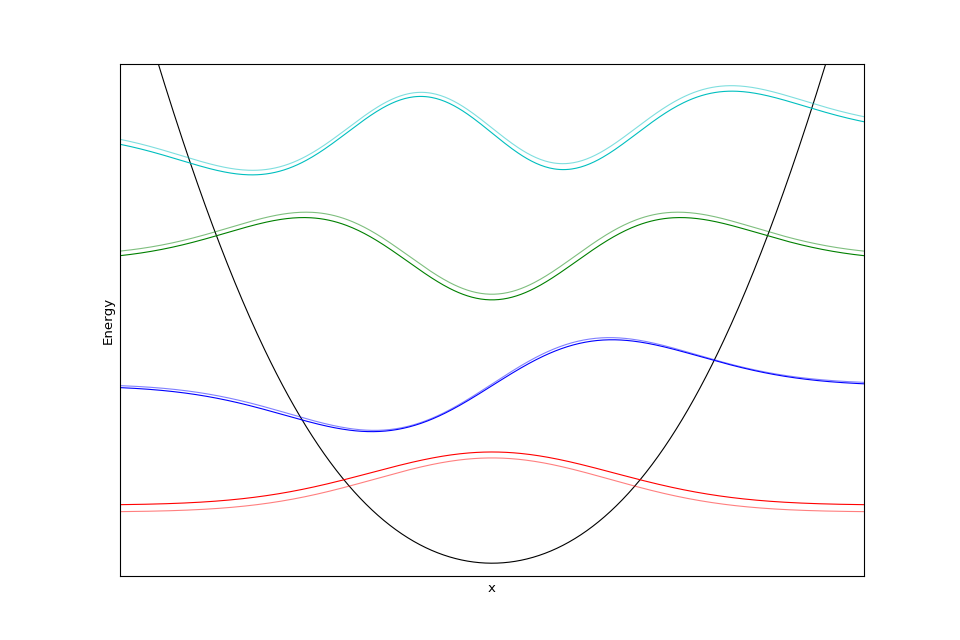

In [30]:
def plot_perturb(omega,m):
    
    colour_dict = {0 : 'r', 1 : 'b', 2 : 'g', 3 : 'c'}
    
    alpha = m*omega
    x = np.linspace(-0.10,0.10,500)

    fig_HO = plt.figure(figsize=(12,8))
    ax = plt.subplot(111)
    ax.set_xlim((np.min(x),np.max(x)))
    
    perturb_h = [perturbation(y) for y in x]
    
    ax.plot(x,0.5*m*omega**2*x**2+perturb_h,'k')
    ax.set_ylim((0,4*omega))
    for i in range(4):
        psi_n = first_order_wf(i,perturbation,omega,m)
        ax.plot(x,200*psi_n(x)+(i+0.5)*omega+first_order_energy_sft(i,perturbation,omega,m), c = colour_dict[i])
    for i in range(4):
        psi_n = unperturb_wf(alpha,i)
        ax.plot(x,200*psi_n(x)+(i+0.5)*omega, c = colour_dict[i], alpha = 0.5)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_ylabel('Energy')
    ax.set_xlabel('x')
    
plot_perturb(2000.,0.5)